# DES SN 5YR Tutorial: Demonstrate cosmology analysis using Des SN 5 year

<img align="left" src = ../_static/images/logo044.jpg width=120 style="padding: 10px"> 
<br><b>Dark Energy Survey Supernova Program</b>

<b>Tutorial</b>
<b>Cosmology analysis using Des SN 5 year</b> <br>
Contact author: Paul Shah<br>

Sheet to demonstrate cosmology analysis using Des SN 5 year

Results will not exactly match Key Paper due to settings, use of Astropy (instead of CAMB) etc.

To run this sheet you will need : 

- Polychord install (available from https://github.com/PolyChord/PolyChordLite)
- Getdist (available from https://github.com/cmbant/getdist/tree/master or package installers like pip or conda)
- standard libraries numpy, matplotlib, astropy, pandas (available from package installers)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM, FlatLambdaCDM
import pandas as pd

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

# setup MPI env for Polychord (you will need to have installed Polychord using MPI compilation option)
%env OMP_NUM_THREADS=8
%env OPENBLAS_NUM_THREADS=8
%env MKL_NUM_THREADS=8
%env VECLIB_MAXIMUM_THREADS=8
%env NUMEXPR_NUM_THREADS=8

/var/folders/61/jz5zv4qn1ml4kvb_mzhpz5500000gn/T/ipykernel_24810/4147049773.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


env: OMP_NUM_THREADS=8
env: OPENBLAS_NUM_THREADS=8
env: MKL_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=8
env: NUMEXPR_NUM_THREADS=8


In [6]:
#set this path to your data location
path = "../../../../DES-SN5YR/4_DISTANCES_COVMAT/"

snfilein = path + "hubble_diagram.txt"
snfilein = path + "DES-SN5YR_HD+Metadata.csv"
sndata = pd.read_csv(snfilein)

In [7]:
sndata.columns

Index(['CID', 'CIDint', 'IDSURVEY', 'TYPE', 'zHEL', 'zHELERR', 'zCMB',
       'zCMBERR', 'zHD', 'zHDERR', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_ZSPEC',
       'HOST_ZSPECERR', 'HOST_RA', 'HOST_DEC', 'HOST_ANGSEP', 'HOST_DDLR',
       'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_COLOR', 'HOST_COLOR_ERR',
       'PKMJD', 'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0',
       'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITPROB',
       'PROB_SCONE', 'PROB_SNIRFV19', 'PROB_SNNDESCC', 'PROB_SNNJ17',
       'PROB_SNNV19', 'MU', 'MUERR_FINAL', 'PROBCC_BEAMS', 'biasCor_mu',
       'biasCor_muCOVSCALE', 'biasCor_muCOVADD'],
      dtype='object')

In [ ]:
zcmb = sndata.zCMB
zhel = sndata.zHEL
dz = 

In [ ]:
(_, zcmb, zhel, dz, mb, dmb)  = np.genfromtxt(snfilein, delimiter='\t', dtype=np.float32, unpack=True) 
nsn = len(zcmb)

ValueError: too many values to unpack (expected 6)

In [ ]:
cov = np.genfromtxt(covmat_file)
cov = cov[1:]
cov = cov.reshape((nsn, nsn))

In [ ]:
# the covariance matrix is systematics only so add statistical error to the diagonal
# note : the statistical errors incorporate the probability of SN mis-classification (see https://arxiv.org/pdf/2401.02929.pdf)
# this down-weights likely contaminants (which mostly lie above the Hubble diagram) in the cosmology fit
np.fill_diagonal(cov, cov.diagonal() + dmb**2)
invcov = np.linalg.inv(cov)
invvars = 1/cov.diagonal()

print('Loaded ',nsn, ' sn')

FileNotFoundError: likelihood/des-y5-sn/hubble_diagram.txt not found.

In [3]:
# we sample H0 and the SN absolute magnitude M (which are degenerate) 
# this is instead of 'script M' = M + 5 log10(c/H0), which is the relevant combination of the two
# doing this is inefficient but transparent, and if desired H0 constraints can be added

nDims = 4 
nDerived = 1 # as an example usage, derived variable is q0 acceleration parameter in Flat wCDM

def likelihood(theta):

    cosmo = FlatwCDM(H0=theta[1], Om0=theta[0], w0 =theta[2])
    M = theta[3]
    ld = cosmo.luminosity_distance(zcmb).value*(1+zhel)/(1+zcmb)  #don't use astropy distmod
    distmod = 5*np.log10(ld)+25
    residual = mb - M - distmod
    chi2 = np.dot(np.dot(residual, invcov),residual)
    q0 = 0.5*(theta[0]+(1+3*theta[2])*(1-theta[0]))
    return -0.5*chi2, [q0]

In [4]:
# uses flat priors for parameters between ranges as below
# other prior forms are available, see https://github.com/PolyChord/PolyChordLite

def prior(hypercube):
    """ Uniform prior from [-1,1]^D. """
    mins = np.array((0.1,60,-1.5,-21), dtype=float)
    maxs = np.array((0.5,80,-0.5,-18), dtype=float)
    return UniformPrior(mins, maxs)(hypercube)

def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [6]:
# Main Polychord settings : uses recommended values
# for a quick run use nlive = 5*nDims, precision_criterion = 0.1
# seed is set for replicability of run

settings = PolyChordSettings(nDims, nDerived)
settings.file_root = 'dessn_fwcdm'
settings.nlive = 25*nDims
settings.num_repeats = 2*nDims
settings.nprior = 10*settings.nlive
settings.feedback = 1
settings.precision_criterion = 0.01
settings.seed = 1234 

# Secondary ones : 
settings.compression_factor = 0.36787944117144233
settings.logzero = -1.0e+30
settings.boost_posterior = 0
settings.posteriors = True
settings.equals = True
settings.cluster_posteriors = False
settings.write_stats = True
settings.write_dead = True
settings.write_live = True
settings.write_paramnames = True
settings.write_prior= True
settings.do_clustering = False
settings.read_resume = False
settings.write_resume = False

In [7]:
output = pypolychord.run_polychord(likelihood, nDims, nDerived, settings, prior, dumper)
output

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.20.1
  release: 1st June 2021
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     100
nDims    :       4
nDerived :       1
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors

generating live points


all live points generated

Speed  1 =  0.120E-01 seconds
number of repeats:            8
started sampling

Last dead point: [ 3.23010399e-01  7.12527032e+01 -7.44348155e-01 -1.93472986e+01
 -2.55873940e-01 -1.00000000e+30 -1.46375601e+03]
_______________
lives      |** |
phantoms   | 7 |
posteriors | 0 |
equals     | 0 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 901
nposterior =                 901
nequals    =                   1
nlike      =                1023
<nlike>    =           0.23   (           0.03 per 

Global evidence:
log(Z)    -828.388489 +/-  0.247996

Local evidences:
log(Z_1)    -828.388489 +/-  0.247996

Run-time information:
ncluster          1
nposterior     2144
nequals         334
ndead          2144
nlive             0
nlike         36240
<nlike>       [0.0]

Parameter estimates:
p0     2.644E-01 +\- 7.429E-02
p1     7.015E+01 +\- 5.889E+00
p2    -8.174E-01 +\- 1.468E-01
p3    -1.929E+01 +\- 1.823E-01
p4    -3.865E-01 +\- 7.209E-02

chains/dessn_fwcdm.txt
Removed no burn in


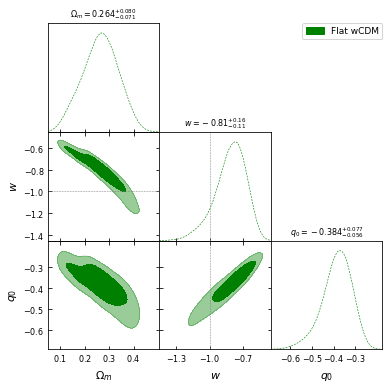

In [8]:
paramnames = [('Omega_m','\Omega_m'), ('H0','H_0'),('w','w'), ('M','M') , ('q0','q_0')]
output.make_paramnames_files(paramnames)
try:
    import getdist.plots
    %matplotlib inline
    posterior = output.posterior
    g = getdist.plots.getSubplotPlotter()
    
    g.triangle_plot(posterior, ['Omega_m', 'w', 'q0'], 
    filled=True, 
    legend_labels=['Flat wCDM'], 
    legend_loc='upper right', 
    line_args=[{'ls':'--', 'color':'green'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['green','darkblue'],
    title_limit=1, # first title limit (for 1D plots) is 68% by default
    markers={'w':-1})
except ImportError:
    print("Install matplotlib and getdist for plotting examples")

In [9]:
#set the residuals from means (note Key Paper Table 2 quotes medians)
(Om0ref, h0ref, wref, M, q0ref) = output.posterior.getMeans()
cosmo = FlatwCDM(H0=h0ref, Om0=Om0ref, w0 = wref)
label0 = 'Flat wCDM, Om0 = %.3f'%Om0ref+' w = %.3f'%wref
ld = cosmo.luminosity_distance(zcmb).value*(1+zhel)/(1+zcmb)  #don't use astropy distmod
distmod = 5*np.log10(ld)+25
residual = mb - M - distmod

# to plot a Hubble diagram, we sort by redshift and assemble buckets comprising <bincount> SN each
bincount = 50

data = {'zcmb': zcmb, 
        'zhel': zhel,
        'res': residual,
        'invvars': invvars,
        'distmod' : distmod,
        'mu' : mb-M
       }
df = pd.DataFrame(data)
df = df.sort_values(by=['zcmb'])
df = df.reset_index(drop=True)
zcmbs = np.array(df['zcmb'])
zhels = np.array(df['zcmb'])
ress = df['res']
wts = df['invvars']
distmods = df['distmod']
mus = df['mu']

resb = []
resberr = []
zb = []
i=0
while i<nsn:
    if i % bincount ==0:
        if i>0:
            resb.append(res1/wt1)
            resberr.append(1/np.sqrt(wt1))
            zb.append(z1/wt1)
        z1 = 0
        res1 = 0
        wt1 =0
        
    z1 += zcmbs[i]* wts[i]
    res1 += ress[i] * wts[i]
    wt1 += wts[i]
    i += 1
resb.append(res1/wt1)
resberr.append(1/np.sqrt(wt1))
zb.append(z1/wt1)

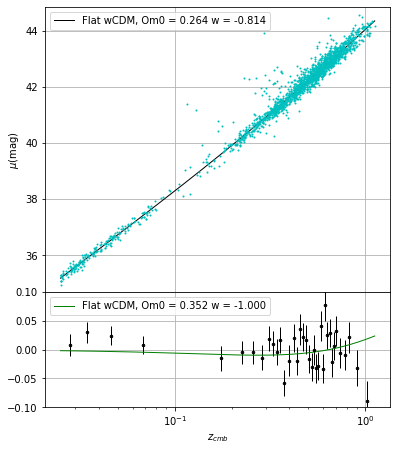

In [10]:
fig1 = plt.figure(1)

# make an upper frame with Hubble diagram, lower frame to 'zoom in' on bucketed residuals and add cosmo comparison
frame1=fig1.add_axes((.1,.5,.8,.99))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(zcmbs, distmods,linestyle='-',linewidth=1, color='k',label=label0)
plt.errorbar(zcmbs, mus,fmt='.c',yerr=dmb,ecolor="c",capsize=0, linewidth=0, markersize=2) 
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
frame1.set_xscale('log')
plt.grid()
plt.ylim([min(distmods)-0.5,max(distmods)+0.5])
plt.legend()
plt.ylabel(r'$\mu (\rm{mag})$')

distmod = cosmo.distmod(zcmbs)

# compare bucketed residuals with this cosmology
Om0ref2 = 0.352
w0ref2 = -1.0
cosmo2 = FlatwCDM(H0=h0ref, Om0=Om0ref2, w0 = w0ref2)
label2 = 'Flat wCDM, Om0 = %.3f'%Om0ref2+' w = %.3f'%w0ref2
distmod2 = cosmo2.distmod(zcmbs)

#lower panel bucketed residual plot
frame2=fig1.add_axes((.1,.1,.8,.4)) 
plt.errorbar(zb,resb,yerr=resberr,fmt='.k',ecolor="k",capsize=0, linewidth=1,markersize=5)
plt.plot(zcmbs, distmod-distmod2 ,linestyle='-',linewidth=1, color='g',label=label2)
frame2.set_xscale('log')
frame2.set_ylim([-0.1, 0.1])
plt.grid()
plt.legend()
plt.xlabel('$z_{cmb}$')
plt.show()